In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# Data sample
Found on [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset), collected from [TMDB](https://www.themoviedb.org/?language=en) and [GroupLens](https://grouplens.org/datasets/movielens/latest/).

In [2]:
#Start importing some of the features available
df = pd.read_csv('data/movies_metadata.csv',dtype={'original_language': 'str','poster_path': 'str'},low_memory=False)
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [3]:
#df.head()

In [4]:
df.shape

(45466, 24)

Approx 45k movies with 24 features 

### Some cleanup

Largely taken from [this notebook](https://www.kaggle.com/rounakbanik/the-story-of-film) accompanying dataset on [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset).

In [5]:
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df = df.drop(['original_title'], axis=1)
df = df.drop(['poster_path'], axis=1)
df = df.drop('adult', axis=1)

Add new feature -- percent profit

In [6]:
df['return'] = df['revenue'] / df['budget']
df['budget'] = df['budget'].replace(0, np.nan)
df[df['return'].isnull()].shape

(40085, 22)

Parse year

In [7]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

Clean up the json stuff

In [8]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Features related to reception of film online

In [9]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [10]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [11]:
df.shape

(45466, 23)

### Add credits data

In [12]:
credits = pd.read_csv('data/credits.csv')

In [13]:
credits['id'] = credits['id'].astype('int')

In [14]:
#Remove some buggy data, luckily not needed for this tournament
df=df[df['id']!='1997-08-20']#bug in data?
df=df[df['id']!='2012-09-29']#bug in data?
df=df[df['id']!='2014-01-01']#bug in data?

In [15]:
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [16]:
df = df.merge(credits, on='id')

In [17]:
df.shape

(45538, 25)

In [18]:
df['cast_size'] = df['cast'].apply(lambda x: len(x))
df['crew_size'] = df['crew'].apply(lambda x: len(x))

### Drop all but the features we'll want later

In [19]:
md=df[['id','title','year','return','budget','runtime','cast_size','crew_size','popularity','vote_count', 'vote_average']]

In [20]:
md.shape


(45538, 11)

## Construct Filmspotting Madness Bracket

In [21]:
def make_match(md, title1, title2, title1win):
    df1=md[(md['title']==title1) & (md['year'] > 1989) & (md['year'] < 2000)]
    df1 = df1.add_suffix('_1')
    df1 = df1.reset_index(drop=True)

    df2=md[(md['title']==title2) & (md['year'] > 1989) & (md['year'] < 2000)]
    df2 = df2.add_suffix('_2')
    df2 = df2.reset_index(drop=True)

    my_match=df1.join(df2)

    my_match['title_1_wins']=title1win
        
    return my_match

In [22]:
#Round 1
my_match = make_match(md, "Pulp Fiction", "Wild at Heart", 1)
my_match = my_match.append( make_match(md, "Saving Private Ryan", "Out of Sight", 1) )
my_match = my_match.append( make_match(md, "Toy Story", "The Sixth Sense", 1) )
my_match = my_match.append( make_match(md, "Schindler's List", "The Iron Giant", 1) )
my_match = my_match.append( make_match(md, "Fight Club", "Safe", 1) )
my_match = my_match.append( make_match(md, "Barton Fink", "Leon: The Professional", 1) )
my_match = my_match.append( make_match(md, "Chungking Express", "My Own Private Idaho", 1) )
my_match = my_match.append( make_match(md, "Jackie Brown", "Princess Mononoke", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs","Close-Up", 1) )
my_match = my_match.append( make_match(md, "Terminator 2: Judgment Day", "The Lion King", 1) )
my_match = my_match.append( make_match(md, "Heat", "JFK", 1) )
my_match = my_match.append( make_match(md, "Dazed and Confused", "The Player", 1) )
my_match = my_match.append( make_match(md, "Boogie Nights", "Naked", 1) )
my_match = my_match.append( make_match(md, "Malcolm X", "Blue", 1) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "The Truman Show", 1) )
my_match = my_match.append( make_match(md, "Groundhog Day", "Edward Scissorhands", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "There's Something About Mary", 1) )
my_match = my_match.append( make_match(md, "Jurassic Park", "Miller's Crossing", 1) )
my_match = my_match.append( make_match(md, "Magnolia", "All About My Mother", 1) )
my_match = my_match.append( make_match(md, "Being John Malkovich", "Office Space", 1) )
my_match = my_match.append( make_match(md, "Unforgiven", "Metropolitan", 1) )
my_match = my_match.append( make_match(md, "Trainspotting", "Clueless", 1) )
my_match = my_match.append( make_match(md, "The Matrix", "The Blair Witch Project", 1) )
my_match = my_match.append( make_match(md, "Hoop Dreams", "The Thin Red Line", 1) )
my_match = my_match.append( make_match(md, "Fargo", "Dead Man", 1) )
my_match = my_match.append( make_match(md, "L.A. Confidential", "Glengarry Glen Ross", 1) )
my_match = my_match.append( make_match(md, "Before Sunrise", "The Insider", 1) )
my_match = my_match.append( make_match(md, "Eyes Wide Shut", "The Piano", 1) )
my_match = my_match.append( make_match(md, "Rushmore", "The Sweet Hereafter", 1) )
my_match = my_match.append( make_match(md, "The Shawshank Redemption", "The Usual Suspects", 1) )
my_match = my_match.append( make_match(md, "Reservoir Dogs", "Boyz n the Hood", 1) )
my_match = my_match.append( make_match(md, "Se7en", "Starship Troopers", 1) )

#Round 2
my_match = my_match.append( make_match(md, "Pulp Fiction", "Saving Private Ryan", 1) )
my_match = my_match.append( make_match(md, "Toy Story", "Schindler's List", 1) )
my_match = my_match.append( make_match(md, "Fight Club", "Barton Fink", 1) )
my_match = my_match.append( make_match(md, "Jackie Brown", "Chungking Express", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "Terminator 2: Judgment Day", 1) )
my_match = my_match.append( make_match(md, "Dazed and Confused", "Heat", 1) )
my_match = my_match.append( make_match(md, "Boogie Nights", "Malcolm X", 1) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "Groundhog Day", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "Jurassic Park", 1) )
my_match = my_match.append( make_match(md, "Magnolia", "Being John Malkovich", 1) )
my_match = my_match.append( make_match(md, "Unforgiven", "Trainspotting", 1) )
my_match = my_match.append( make_match(md, "The Matrix", "Hoop Dreams", 1) )
my_match = my_match.append( make_match(md, "Fargo", "L.A. Confidential", 1) )
my_match = my_match.append( make_match(md, "Before Sunrise", "Eyes Wide Shut", 1) )
my_match = my_match.append( make_match(md, "Rushmore", "The Shawshank Redemption", 1) )
my_match = my_match.append( make_match(md, "Reservoir Dogs", "Se7en", 1) )

#Round 3
my_match = my_match.append( make_match(md, "Pulp Fiction", "Toy Story", 1) )
my_match = my_match.append( make_match(md, "Fight Club", "Jackie Brown", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "Dazed and Confused", 1) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "Boogie Nights", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "Being John Malkovich", 1) )
my_match = my_match.append( make_match(md, "The Matrix", "Unforgiven", 1) )
my_match = my_match.append( make_match(md, "Fargo", "Before Sunrise", 1) )
my_match = my_match.append( make_match(md, "Rushmore", "Se7en", 1) )

#Round 4
my_match = my_match.append( make_match(md, "Pulp Fiction", "Fight Club", 1) )
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "The Big Lebowski", 1) )
my_match = my_match.append( make_match(md, "GoodFellas", "The Matrix", 1) )
my_match = my_match.append( make_match(md, "Fargo", "Rushmore", 1) )

#Round 5
my_match = my_match.append( make_match(md, "Pulp Fiction", "The Silence of the Lambs", 1) )
my_match = my_match.append( make_match(md, "Fargo", "GoodFellas", 1) )

my_match

,id_1,title_1,year_1,return_1,budget_1,runtime_1,cast_size_1,crew_size_1,popularity_1,vote_count_1,...,year_2,return_2,budget_2,runtime_2,cast_size_2,crew_size_2,popularity_2,vote_count_2,vote_average_2,title_1_wins
0,680,Pulp Fiction,1994.0,26.741095,8000000.0,154.0,10812,15131,140.950236,8670.0,...,1990.0,1.532658,9500000.0,124.0,4034,2564,8.528622,341.0,7.0,1
0,857,Saving Private Ryan,1998.0,6.883442,70000000.0,169.0,7638,19327,21.758054,5148.0,...,1998.0,1.619699,48000000.0,123.0,3200,2223,7.349812,338.0,6.5,1
0,862,Toy Story,1995.0,12.451801,30000000.0,81.0,2632,18654,21.946943,5415.0,...,1999.0,16.820157,40000000.0,107.0,9961,15334,18.449169,3223.0,7.7,1
0,424,Schindler's List,1993.0,14.607526,22000000.0,195.0,6097,6272,41.725123,4436.0,...,1999.0,0.330847,70000000.0,86.0,6121,7925,15.441459,1470.0,7.6,1
0,550,Fight Club,1999.0,1.600853,63000000.0,139.0,15580,18422,63.869599,9678.0,...,1995.0,NaN,NaN,119.0,2505,1566,8.180047,62.0,7.2,1
0,290,Barton Fink,1991.0,0.683771,9000000.0,116.0,2753,2863,8.387026,450.0,...,1994.0,2.830311,16000000.0,110.0,7748,3314,20.477329,4293.0,8.2,1
0,11104,Chungking Express,1994.0,NaN,NaN,102.0,2333,2382,6.778979,249.0,...,1991.0,NaN,2500000.0,104.0,2373,1911,7.289727,218.0,7.1,1
0,184,Jackie Brown,1997.0,3.306097,12000000.0,154.0,6464,1641,16.415498,1580.0,...,1997.0,6.014163,26500000.0,134.0,2860,11821,17.166725,2041.0,8.2,1
0,274,The Silence of the Lambs,1991.0,14.354891,19000000.0,119.0,11529,14232,4.307222,4549.0,...,1990.0,NaN,NaN,98.0,2857,1108,2.972346,53.0,8.0,1
0,280,Terminator 2: Judgment Day,1991.0,5.200000,100000000.0,137.0,8207,9389,22.661695,4274.0,...,1994.0,17.516484,45000000.0,89.0,5996,6252,21.605761,5520.0,8.0,1


#### Add same matches with movies in reverse order so NN doesn't learn preference for arbitrary movie number ordering
NB: should remove duplicates in test data 

In [23]:
#Round 1
my_match = my_match.append( make_match(md, "Wild at Heart", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "Out of Sight", "Saving Private Ryan", 0) )
my_match = my_match.append( make_match(md, "The Sixth Sense", "Toy Story", 0) )
my_match = my_match.append( make_match(md, "The Iron Giant", "Schindler's List", 0) )
my_match = my_match.append( make_match(md, "Safe", "Fight Club", 0) )
my_match = my_match.append( make_match(md, "Leon: The Professional", "Barton Fink", 0) )
my_match = my_match.append( make_match(md, "My Own Private Idaho", "Chungking Express", 0) )
my_match = my_match.append( make_match(md, "Princess Mononoke", "Jackie Brown", 0) )
my_match = my_match.append( make_match(md, "Close-Up", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "The Lion King", "Terminator 2: Judgment Day", 0) )
my_match = my_match.append( make_match(md, "JFK", "Heat", 0) )
my_match = my_match.append( make_match(md, "The Player", "Dazed and Confused", 0) )
my_match = my_match.append( make_match(md, "Naked", "Boogie Nights", 0) )
my_match = my_match.append( make_match(md, "Blue", "Malcolm X", 0) )
my_match = my_match.append( make_match(md, "The Truman Show", "The Big Lebowski", 0) )
my_match = my_match.append( make_match(md, "Edward Scissorhands", "Groundhog Day", 0) )
my_match = my_match.append( make_match(md, "There's Something About Mary", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Miller's Crossing", "Jurassic Park", 0) )
my_match = my_match.append( make_match(md, "All About My Mother", "Magnolia", 0) )
my_match = my_match.append( make_match(md, "Office Space", "Being John Malkovich", 0) )
my_match = my_match.append( make_match(md, "Metropolitan", "Unforgiven", 0) )
my_match = my_match.append( make_match(md, "Clueless", "Trainspotting", 0) )
my_match = my_match.append( make_match(md, "The Blair Witch Project", "The Matrix", 0) )
my_match = my_match.append( make_match(md, "The Thin Red Line", "Hoop Dreams", 0) )
my_match = my_match.append( make_match(md, "Dead Man", "Fargo", 0) )
my_match = my_match.append( make_match(md, "Glengarry Glen Ross", "L.A. Confidential", 0) )
my_match = my_match.append( make_match(md, "The Insider", "Before Sunrise", 0) )
my_match = my_match.append( make_match(md, "The Piano", "Eyes Wide Shut", 0) )
my_match = my_match.append( make_match(md, "The Sweet Hereafter", "Rushmore", 0) )
my_match = my_match.append( make_match(md, "The Usual Suspects", "The Shawshank Redemption", 0) )
my_match = my_match.append( make_match(md, "Boyz n the Hood", "Reservoir Dogs", 0) )
my_match = my_match.append( make_match(md, "Starship Troopers", "Se7en", 0) )

#Round 2
my_match = my_match.append( make_match(md, "Saving Private Ryan", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "Schindler's List", "Toy Story", 0) )
my_match = my_match.append( make_match(md, "Barton Fink", "Fight Club", 0) )
my_match = my_match.append( make_match(md, "Chungking Express", "Jackie Brown", 0) )
my_match = my_match.append( make_match(md, "Terminator 2: Judgment Day", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "Heat", "Dazed and Confused", 0) )
my_match = my_match.append( make_match(md, "Malcolm X", "Boogie Nights", 0) )
my_match = my_match.append( make_match(md, "Groundhog Day", "The Big Lebowski", 0) )
my_match = my_match.append( make_match(md, "Jurassic Park", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Being John Malkovich", "Magnolia", 0) )
my_match = my_match.append( make_match(md, "Trainspotting", "Unforgiven", 0) )
my_match = my_match.append( make_match(md, "Hoop Dreams", "The Matrix", 0) )
my_match = my_match.append( make_match(md, "L.A. Confidential", "Fargo", 0) )
my_match = my_match.append( make_match(md, "Eyes Wide Shut", "Before Sunrise", 0) )
my_match = my_match.append( make_match(md, "The Shawshank Redemption", "Rushmore", 0) )
my_match = my_match.append( make_match(md, "Se7en", "Reservoir Dogs", 0) )

#Round 3
my_match = my_match.append( make_match(md, "Toy Story", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "Jackie Brown", "Fight Club", 0) )
my_match = my_match.append( make_match(md, "Dazed and Confused", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "Boogie Nights", "The Big Lebowski", 0) )
my_match = my_match.append( make_match(md, "Being John Malkovich", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Unforgiven", "The Matrix", 0) )
my_match = my_match.append( make_match(md, "Before Sunri se", "Fargo", 0) )
my_match = my_match.append( make_match(md, "Se7en", "Rushmore", 0) )

#Round 4
my_match = my_match.append( make_match(md, "Fight Club", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "The Big Lebowski", "The Silence of the Lambs", 0) )
my_match = my_match.append( make_match(md, "The Matrix", "GoodFellas", 0) )
my_match = my_match.append( make_match(md, "Rushmore", "Fargo", 0) )

#Round 5
my_match = my_match.append( make_match(md, "The Silence of the Lambs", "Pulp Fiction", 0) )
my_match = my_match.append( make_match(md, "GoodFellas", "Fargo", 0) )



### Bit more cleaning on match data

In [24]:
my_match = my_match.fillna(-1) #replace NaN with -1

## Final feature selection and prep

In [25]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

In [26]:
my_match

,id_1,title_1,year_1,return_1,budget_1,runtime_1,cast_size_1,crew_size_1,popularity_1,vote_count_1,...,year_2,return_2,budget_2,runtime_2,cast_size_2,crew_size_2,popularity_2,vote_count_2,vote_average_2,title_1_wins
0,680,Pulp Fiction,1994.0,26.741095,8000000.0,154.0,10812,15131,140.950236,8670.0,...,1990.0,1.532658,9500000.0,124.0,4034,2564,8.528622,341.0,7.0,1
0,857,Saving Private Ryan,1998.0,6.883442,70000000.0,169.0,7638,19327,21.758054,5148.0,...,1998.0,1.619699,48000000.0,123.0,3200,2223,7.349812,338.0,6.5,1
0,862,Toy Story,1995.0,12.451801,30000000.0,81.0,2632,18654,21.946943,5415.0,...,1999.0,16.820157,40000000.0,107.0,9961,15334,18.449169,3223.0,7.7,1
0,424,Schindler's List,1993.0,14.607526,22000000.0,195.0,6097,6272,41.725123,4436.0,...,1999.0,0.330847,70000000.0,86.0,6121,7925,15.441459,1470.0,7.6,1
0,550,Fight Club,1999.0,1.600853,63000000.0,139.0,15580,18422,63.869599,9678.0,...,1995.0,-1.000000,-1.0,119.0,2505,1566,8.180047,62.0,7.2,1
0,290,Barton Fink,1991.0,0.683771,9000000.0,116.0,2753,2863,8.387026,450.0,...,1994.0,2.830311,16000000.0,110.0,7748,3314,20.477329,4293.0,8.2,1
0,11104,Chungking Express,1994.0,-1.000000,-1.0,102.0,2333,2382,6.778979,249.0,...,1991.0,-1.000000,2500000.0,104.0,2373,1911,7.289727,218.0,7.1,1
0,184,Jackie Brown,1997.0,3.306097,12000000.0,154.0,6464,1641,16.415498,1580.0,...,1997.0,6.014163,26500000.0,134.0,2860,11821,17.166725,2041.0,8.2,1
0,274,The Silence of the Lambs,1991.0,14.354891,19000000.0,119.0,11529,14232,4.307222,4549.0,...,1990.0,-1.000000,-1.0,98.0,2857,1108,2.972346,53.0,8.0,1
0,280,Terminator 2: Judgment Day,1991.0,5.200000,100000000.0,137.0,8207,9389,22.661695,4274.0,...,1994.0,17.516484,45000000.0,89.0,5996,6252,21.605761,5520.0,8.0,1


In [27]:
#Simplest splitting -- random.  Could rethink this to e.g. keep final match movies equal in # of samples?
my_match_train, my_match_test = train_test_split(my_match, test_size=0.33, random_state=42)

In [28]:
my_match_train.shape

(82, 23)

In [29]:
my_match_test.shape

(41, 23)

In [30]:
#These are the train samples we will remove because they are in test set with reverse order
for index, row in my_match_train.iterrows(): 
    #print(row['title_1'], row['title_2'])
    for index2, row2 in my_match_test.iterrows():
        if(row['title_1']==row2['title_2'] and row['title_2']==row2['title_1']):
            print(row['title_1'], row['title_2'])

Rushmore The Sweet Hereafter
GoodFellas There's Something About Mary
All About My Mother Magnolia
Eyes Wide Shut The Piano
Terminator 2: Judgment Day The Silence of the Lambs
Eyes Wide Shut Before Sunrise
Schindler's List The Iron Giant
Boogie Nights Malcolm X
JFK Heat
Rushmore The Shawshank Redemption
The Insider Before Sunrise
Trainspotting Unforgiven
The Silence of the Lambs The Big Lebowski
Pulp Fiction Saving Private Ryan
Unforgiven The Matrix
Fargo Rushmore
The Shawshank Redemption The Usual Suspects
Se7en Reservoir Dogs
Naked Boogie Nights
Dead Man Fargo
The Lion King Terminator 2: Judgment Day
L.A. Confidential Fargo
The Big Lebowski The Truman Show
Boyz n the Hood Reservoir Dogs
Jurassic Park GoodFellas


In [31]:
#Here we remove from training set any of the reverse order duplicate matches that exist in the test set
keys1 = ['title_1', 'title_2']
keys2 = ['title_2', 'title_1']

i_train = my_match_train.set_index(keys1).index
i_test = my_match_test.set_index(keys2).index
my_match_train = my_match_train[~i_train.isin(i_test)]

In [32]:
#i_train

In [33]:
#i_test

In [34]:
#double check they're gone
for index, row in my_match_train.iterrows(): 
    #print(row['title_1'], row['title_2'])
    for index2, row2 in my_match_test.iterrows():
        if(row['title_1']==row2['title_2'] and row['title_2']==row2['title_1']):
            print(row['title_1'], row['title_2'])

In [35]:
#X_train = my_match_train[['year_1','budget_1','return_1','cast_size_1','crew_size_1','popularity_1','vote_count_1',"vote_average_1",'year_2','budget_2','return_2','cast_size_2','crew_size_2','popularity_2','vote_count_2',"vote_average_2"]]
#X_test = my_match_test[['year_1','budget_1','return_1','cast_size_1','crew_size_1','popularity_1','vote_count_1',"vote_average_1",'year_2','budget_2','return_2','cast_size_2','crew_size_2','popularity_2','vote_count_2',"vote_average_2"]]

#X_train = my_match_train[['year_1','budget_1','return_1','cast_size_1','popularity_1','vote_count_1',"vote_average_1",'year_2','budget_2','return_2','cast_size_2','popularity_2','vote_count_2',"vote_average_2"]]
#X_test = my_match_test[['year_1','budget_1','return_1','cast_size_1','popularity_1','vote_count_1',"vote_average_1",'year_2','budget_2','return_2','cast_size_2','popularity_2','vote_count_2',"vote_average_2"]]

X_train = my_match_train[['return_1','popularity_1','vote_count_1',"vote_average_1",'return_2','popularity_2','vote_count_2',"vote_average_2"]]
X_test = my_match_test[['return_1','popularity_1','vote_count_1',"vote_average_1",'return_2','popularity_2','vote_count_2',"vote_average_2"]]

#X_train = my_match_train[['popularity_1','vote_count_1',"vote_average_1",'popularity_2','vote_count_2',"vote_average_2"]]
#X_test = my_match_test[['popularity_1','vote_count_1',"vote_average_1",'popularity_2','vote_count_2',"vote_average_2"]]

In [36]:
X_train.shape

(57, 8)

In [37]:
X_test.shape

(41, 8)

In [38]:
X_train = minmax_scale(X_train) #normalize
X_test = minmax_scale(X_test) #normalize


In [39]:
y_train = my_match_train[['title_1_wins']]
y_test = my_match_test[['title_1_wins']]

In [40]:
X_train.shape[1:2]

(8,)

In [41]:
y_train.shape[1]

1

# Neural Network
Not optimal with so few features though

In [42]:

from sklearn import metrics
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib
#from callbacks import all_callbacks #this doesn't work

/Users/kreis/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Setup Neural Network Model

In [43]:
model = Sequential()

In [44]:
#Not really ideal with so few samples...  Let's see how this goes
model.add(Dense(12, input_shape = X_train.shape[1:2], activation = 'relu', kernel_initializer='lecun_uniform'))
#model.add(Dense(12, activation = 'relu', kernel_initializer='lecun_uniform'))
#model.add(Dense(6, activation = 'relu', kernel_initializer='lecun_uniform'))
model.add(Dense(y_train.shape[1], activation = 'sigmoid', kernel_initializer='lecun_uniform'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [45]:
# For a binary classification problem (https://keras.io/getting-started/sequential-model-guide/)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
hist = model.fit(X_train, y_train, epochs=300, batch_size=10)


Epoch 1/300
57/57 [==============================] - 0s 2ms/step - loss: 0.7168 - acc: 0.4035
Epoch 2/300
57/57 [==============================] - 0s 230us/step - loss: 0.7144 - acc: 0.4211
Epoch 3/300
57/57 [==============================] - 0s 210us/step - loss: 0.7129 - acc: 0.4211
Epoch 4/300
57/57 [==============================] - 0s 202us/step - loss: 0.7113 - acc: 0.4211
Epoch 5/300
57/57 [==============================] - 0s 164us/step - loss: 0.7101 - acc: 0.4211
Epoch 6/300
57/57 [==============================] - 0s 177us/step - loss: 0.7088 - acc: 0.4211
Epoch 7/300
57/57 [==============================] - 0s 186us/step - loss: 0.7074 - acc: 0.4211
Epoch 8/300
57/57 [==============================] - 0s 169us/step - loss: 0.7062 - acc: 0.4211
Epoch 9/300
57/57 [==============================] - 0s 209us/step - loss: 0.7047 - acc: 0.4386
Epoch 10/300
57/57 [==============================] - 0s 229us/step - loss: 0.7037 - acc: 0.4737
Epoch 11/300
57/57 [=====================

57/57 [==============================] - 0s 257us/step - loss: 0.6138 - acc: 0.7193
Epoch 86/300
57/57 [==============================] - 0s 293us/step - loss: 0.6123 - acc: 0.7193
Epoch 87/300
57/57 [==============================] - 0s 196us/step - loss: 0.6107 - acc: 0.7193
Epoch 88/300
57/57 [==============================] - 0s 186us/step - loss: 0.6095 - acc: 0.7193
Epoch 89/300
57/57 [==============================] - 0s 293us/step - loss: 0.6078 - acc: 0.7193
Epoch 90/300
57/57 [==============================] - 0s 251us/step - loss: 0.6067 - acc: 0.7193
Epoch 91/300
57/57 [==============================] - 0s 218us/step - loss: 0.6057 - acc: 0.7193
Epoch 92/300
57/57 [==============================] - 0s 213us/step - loss: 0.6042 - acc: 0.7193
Epoch 93/300
57/57 [==============================] - 0s 217us/step - loss: 0.6026 - acc: 0.7193
Epoch 94/300
57/57 [==============================] - 0s 239us/step - loss: 0.6013 - acc: 0.7193
Epoch 95/300
57/57 [=======================

57/57 [==============================] - 0s 351us/step - loss: 0.5347 - acc: 0.7544
Epoch 169/300
57/57 [==============================] - 0s 271us/step - loss: 0.5352 - acc: 0.7544
Epoch 170/300
57/57 [==============================] - 0s 279us/step - loss: 0.5343 - acc: 0.7544
Epoch 171/300
57/57 [==============================] - 0s 211us/step - loss: 0.5334 - acc: 0.7368
Epoch 172/300
57/57 [==============================] - 0s 269us/step - loss: 0.5336 - acc: 0.7193
Epoch 173/300
57/57 [==============================] - 0s 274us/step - loss: 0.5325 - acc: 0.7368
Epoch 174/300
57/57 [==============================] - 0s 339us/step - loss: 0.5325 - acc: 0.7544
Epoch 175/300
57/57 [==============================] - 0s 276us/step - loss: 0.5318 - acc: 0.7544
Epoch 176/300
57/57 [==============================] - 0s 245us/step - loss: 0.5318 - acc: 0.7368
Epoch 177/300
57/57 [==============================] - 0s 274us/step - loss: 0.5310 - acc: 0.7368
Epoch 178/300
57/57 [=============

57/57 [==============================] - 0s 224us/step - loss: 0.5107 - acc: 0.7719
Epoch 252/300
57/57 [==============================] - 0s 230us/step - loss: 0.5108 - acc: 0.7719
Epoch 253/300
57/57 [==============================] - 0s 301us/step - loss: 0.5112 - acc: 0.7544
Epoch 254/300
57/57 [==============================] - 0s 243us/step - loss: 0.5096 - acc: 0.7719
Epoch 255/300
57/57 [==============================] - 0s 220us/step - loss: 0.5103 - acc: 0.7719
Epoch 256/300
57/57 [==============================] - 0s 217us/step - loss: 0.5097 - acc: 0.7719
Epoch 257/300
57/57 [==============================] - 0s 214us/step - loss: 0.5098 - acc: 0.7719
Epoch 258/300
57/57 [==============================] - 0s 241us/step - loss: 0.5102 - acc: 0.7368
Epoch 259/300
57/57 [==============================] - 0s 380us/step - loss: 0.5096 - acc: 0.7719
Epoch 260/300
57/57 [==============================] - 0s 290us/step - loss: 0.5089 - acc: 0.7719
Epoch 261/300
57/57 [=============

In [47]:
 model.evaluate(X_test, y_test, batch_size=10) #returns loss and accuracy

41/41 [==============================] - 0s 1ms/step


[0.5765632012995278, 0.7317073112580834]

In [48]:
#confusion matrix
print(metrics.confusion_matrix(y_test, model.predict(X_test)>0.5)) 

[[12  7]
 [ 4 18]]


In [49]:
y_test

,title_1_wins
0,1
0,1
0,1
0,0
0,1
0,1
0,0
0,0
0,1
0,1


In [50]:
model.predict(X_test)

array([[0.5621418 ],
       [0.59577554],
       [0.52447903],
       [0.47629595],
       [0.9231039 ],
       [0.62501997],
       [0.0849981 ],
       [0.506683  ],
       [0.8234374 ],
       [0.2746559 ],
       [0.85723484],
       [0.67094076],
       [0.6444338 ],
       [0.29432663],
       [0.23955908],
       [0.6021515 ],
       [0.65957963],
       [0.7475712 ],
       [0.8097431 ],
       [0.9427631 ],
       [0.60231036],
       [0.6033908 ],
       [0.10918156],
       [0.9016332 ],
       [0.69090617],
       [0.46514586],
       [0.52956676],
       [0.20299233],
       [0.640695  ],
       [0.41335425],
       [0.5580503 ],
       [0.493389  ],
       [0.44393837],
       [0.4640703 ],
       [0.51196605],
       [0.45473325],
       [0.28930405],
       [0.76036924],
       [0.2952217 ],
       [0.31699046],
       [0.52554655]], dtype=float32)

In [51]:
print(hist.history.keys())

dict_keys(['loss', 'acc'])


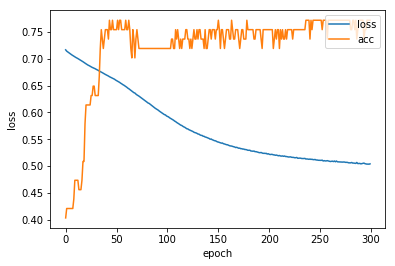

In [57]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"])
plt.plot(hist.history["acc"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "acc"], loc="upper right")
plt.show()

# Logistic Regression

In [53]:
from sklearn import linear_model


In [54]:
y_train = y_train.as_matrix()
y_train = np.squeeze(y_train)
y_train.shape



(57,)

In [55]:
model = linear_model.LogisticRegression()
model = model.fit(X_train, y_train)



In [56]:
# check the accuracy on the test set
model.score(X_test, y_test)

0.7804878048780488